In [619]:
import h5py
import numpy as np

# --- Parameters ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  # Update this
h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export

sampling_rate = 20000  # Hz

# --- Load spike times from HDF5 ---
all_spikes = {}
with h5py.File(h5_in_path, 'r') as f:
    unit_ids = sorted(f['/spikes'].keys(), key=lambda x: int(x.split('_')[1]))
    for uid in unit_ids:
        unit_index = int(uid.split('_')[1])
        raw = f[f'/spikes/{uid}'][:]
        if raw.ndim == 1 and raw.shape[0] == 1:
            spikes_sec = np.array(raw[0]).flatten()
        else:
            spikes_sec = np.array(raw).flatten()
        spikes_samples = np.round(spikes_sec * sampling_rate).astype(np.int32)
        all_spikes[unit_index] = spikes_samples

    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]


spike_times = all_spikes[179]

In [278]:
print(spike_times[:5])

[2215 2267 2397 2531 2757]


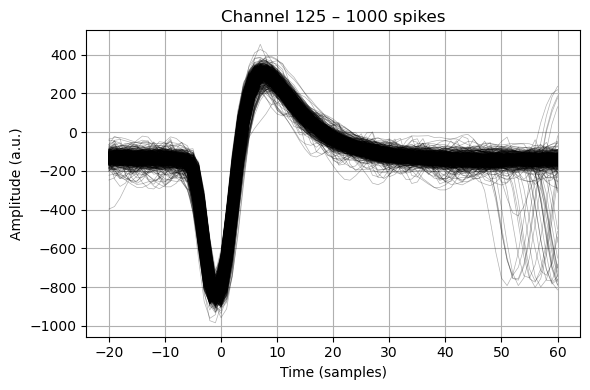

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from extract_data_snippets import extract_snippets

spike_times = all_spikes[179]

# --- Inputs ---
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  
spike_times_subset = spike_times[:1000]  # take first 100 spikes
selected_channel = 126  # change to the channel you want
window = (-20, 60)

# --- Extract snippets ---
snips = extract_snippets(dat_path=dat_path,
                         spike_times=spike_times_subset,
                         window=window,
                         n_channels=512,
                         dtype='int16')  # adjust if different

# snips shape: [n_channels x snippet_len x num_spikes]
traces = snips[selected_channel-1, :, :]  # shape: [snippet_len x num_spikes]

# --- Plot ---
plt.figure(figsize=(6, 4))
t = np.arange(window[0], window[1] + 1)  # x-axis in samples

for i in range(traces.shape[1]):
    plt.plot(t, traces[:, i], color='black', alpha=0.3, linewidth=0.5)

plt.title(f'Channel {selected_channel-1} – {traces.shape[1]} spikes')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (a.u.)')
plt.grid(True)
plt.tight_layout()
plt.show()


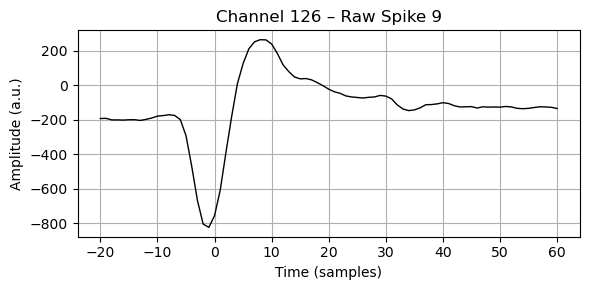

In [211]:
# --- Pick a spike index to inspect ---
spike_idx = 9  # change this to any index you want to inspect

plt.figure(figsize=(6, 3))
plt.plot(t, traces[:, spike_idx], color='black', linewidth=1)
plt.title(f'Channel {selected_channel} – Raw Spike {spike_idx}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (a.u.)')
plt.grid(True)
plt.tight_layout()
plt.show()


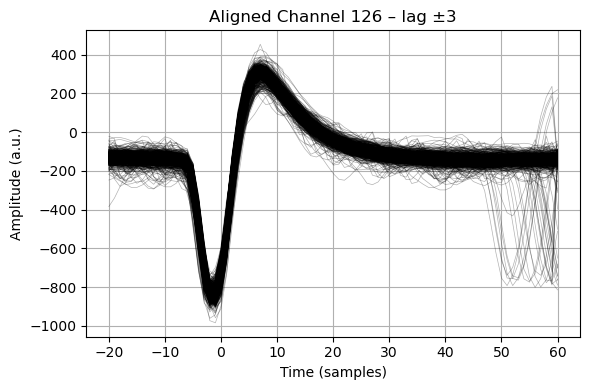

In [212]:
from scipy.signal import correlate

# --- Parameters ---
ref_index = 8  # index of the spike to align to (0 = first spike)
max_lag = 3    # maximum lag (in samples) to search over

# --- Extract reference trace ---
ref_trace = traces[:, ref_index]  # shape: [snippet_len]

# --- Set alignment window (inclusive range) ---
align_start = 10
align_end = 30

# Extract reference segment
ref_segment = ref_trace[align_start:align_end + 1]

# Initialize
aligned_traces = np.zeros_like(traces)
shifts = []

for i in range(traces.shape[1]):
    trace = traces[:, i]
    segment = trace[align_start:align_end + 1]

    # Cross-correlate within windowed segment
    xc = correlate(segment, ref_segment, mode='full')
    lags = np.arange(-len(segment) + 1, len(segment))
    
    # Limit to small lag window
    center = len(xc) // 2
    xc_window = xc[center - max_lag:center + max_lag + 1]
    best_shift = np.argmax(xc_window) - max_lag
    shifts.append(best_shift)

    # Apply shift to the full trace
    aligned_traces[:, i] = np.roll(trace, -best_shift)


# --- Plot aligned traces ---
plt.figure(figsize=(6, 4))
for i in range(aligned_traces.shape[1]):
    plt.plot(t, aligned_traces[:, i], color='black', alpha=0.3, linewidth=0.5)

plt.title(f'Aligned Channel {selected_channel} – lag ±{max_lag}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (a.u.)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: visualize shift distribution
# plt.figure()
# plt.hist(shifts, bins=np.arange(-max_lag-0.5, max_lag+1.5), edgecolor='k')
# plt.title('Alignment shifts')
# plt.xlabel('Samples shifted')
# plt.ylabel('Count')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


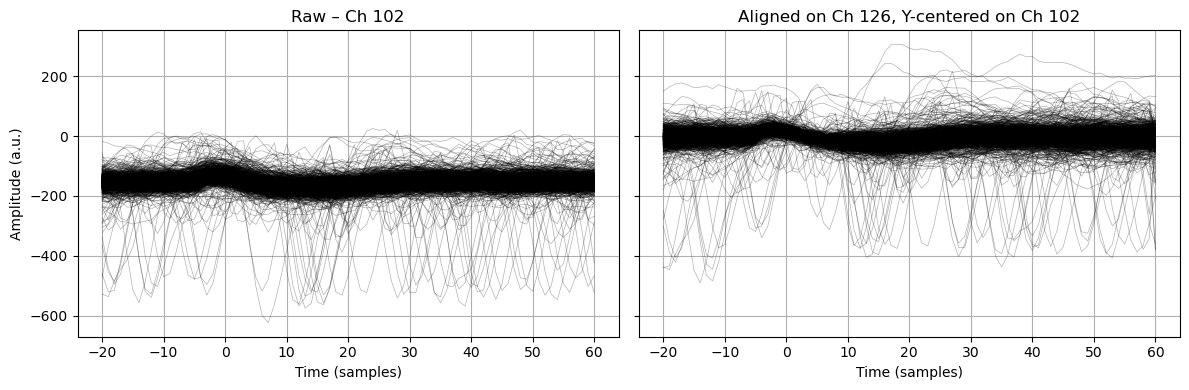

In [213]:
from scipy.signal import correlate

# --- Parameters ---
ref_index = 8  # index of the spike to align to (0 = first spike)
max_lag = 3    # maximum lag (in samples) to search over

# --- Channels ---
align_channel = 126-1   # channel to compute alignment on
plot_channel = 102-1    # different channel to apply shifts to and visualize
#plot_channel = 163-1    # different channel to apply shifts to and visualize

# --- Extract traces from both channels ---
ref_trace = snips[align_channel, :, ref_index]
ref_segment = ref_trace[align_start:align_end + 1]

traces_align = snips[align_channel, :, :]   # [time x spikes]
traces_plot = snips[plot_channel, :, :]     # [time x spikes]

# --- Align based on align_channel, apply to plot_channel ---
aligned_traces = np.zeros_like(traces_plot)
shifts = []

for i in range(traces_plot.shape[1]):
    segment = traces_align[align_start:align_end + 1, i]
    xc = correlate(segment, ref_segment, mode='full')
    center = len(xc) // 2
    xc_window = xc[center - max_lag:center + max_lag + 1]
    best_shift = np.argmax(xc_window) - max_lag
    shifts.append(best_shift)

    # Shift trace from plot_channel using alignment from align_channel
    aligned_traces[:, i] = np.roll(traces_plot[:, i], -best_shift)

# --- Y-axis centering parameters ---
y_center_start = 15
y_center_end = 30

# Create vertically centered traces (without modifying original aligned_traces)
centered_traces = np.zeros_like(aligned_traces)

for i in range(aligned_traces.shape[1]):
    trace = aligned_traces[:, i]
    y_window = trace[y_center_start:y_center_end + 1]
    y_offset = np.mean(y_window)
    centered_traces[:, i] = trace - y_offset


fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Left: raw (unaligned) traces on plot_channel ---
for i in range(traces_plot.shape[1]):
    axs[0].plot(t, traces_plot[:, i], color='black', alpha=0.3, linewidth=0.5)

axs[0].set_title(f'Raw – Ch {plot_channel+1}')
axs[0].set_xlabel('Time (samples)')
axs[0].set_ylabel('Amplitude (a.u.)')
axs[0].grid(True)

# --- Right: aligned + y-centered traces ---
for i in range(centered_traces.shape[1]):
    axs[1].plot(t, centered_traces[:, i], color='black', alpha=0.3, linewidth=0.5)

axs[1].set_title(f'Aligned on Ch {align_channel+1}, Y-centered on Ch {plot_channel+1}')
axs[1].set_xlabel('Time (samples)')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# --- Plot ---
#plt.figure(figsize=(6, 4))
#for i in range(aligned_traces.shape[1]):
#    plt.plot(t, aligned_traces[:, i], color='black', alpha=0.3, linewidth=0.5)

#plt.title(f'Aligned (via channel {align_channel+1}) – Viewed on channel {plot_channel+1}')
#plt.xlabel('Time (samples)')
#plt.ylabel('Amplitude (a.u.)')
#plt.grid(True)
#plt.tight_layout()
#plt.show()


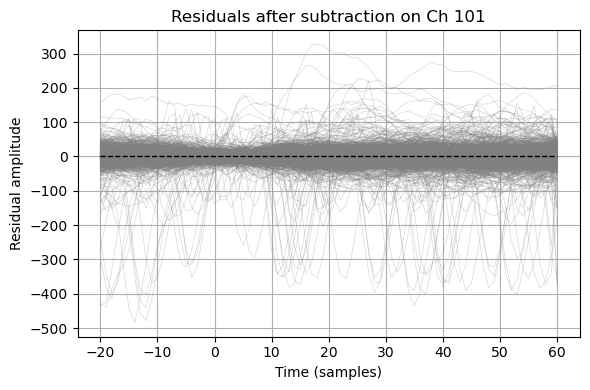

In [214]:
# --- Step 1: Compute mean waveform
mean_waveform = np.mean(centered_traces, axis=1)  # shape: [T]

# --- Step 2: Subtract from each trace
residuals = centered_traces - mean_waveform[:, None]  # shape: [T x N]

# --- Step 3: Plot residuals overlay
plt.figure(figsize=(6, 4))
for i in range(residuals.shape[1]):
    plt.plot(t, residuals[:, i], color='gray', alpha=0.3, linewidth=0.5)

plt.plot(t, np.zeros_like(t), color='black', linestyle='--', linewidth=1)
plt.title(f'Residuals after subtraction on Ch {plot_channel}')
plt.xlabel('Time (samples)')
plt.ylabel('Residual amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


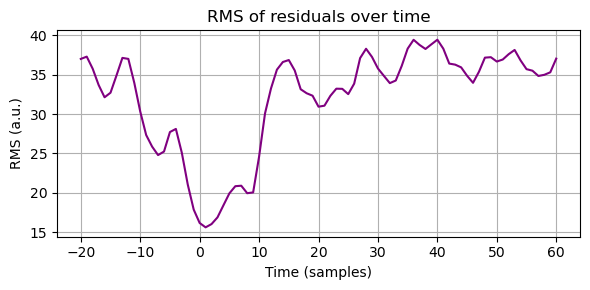

In [215]:
# Compute RMS of residuals at each timepoint
rms = np.sqrt(np.mean(residuals**2, axis=1))

plt.figure(figsize=(6, 3))
plt.plot(t, rms, color='purple')
plt.title('RMS of residuals over time')
plt.xlabel('Time (samples)')
plt.ylabel('RMS (a.u.)')
plt.grid(True)
plt.tight_layout()
plt.show()


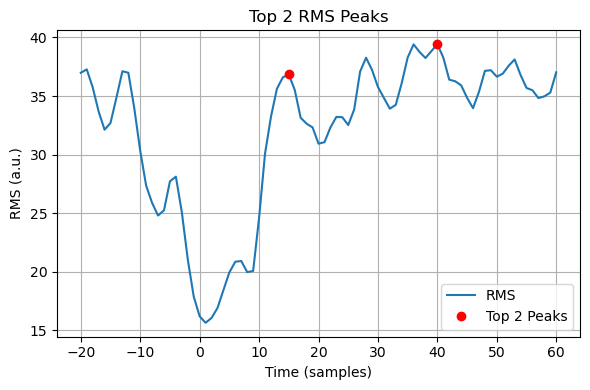

[35 60]


In [216]:
from scipy.signal import find_peaks

# Assume 'rms' contains your RMS residual trace
peaks, props = find_peaks(rms, prominence=5)  # adjust prominence as needed

# Sort peaks by prominence (or height) and get the top 2
sorted_indices = np.argsort(props['prominences'])[::-1]
top2 = sorted_indices[:2]

peak_indices = peaks[top2]
peak_times = t[peak_indices]
peak_values = rms[peak_indices]

# --- Visualize to verify ---
plt.figure(figsize=(6, 4))
plt.plot(t, rms, label='RMS')
plt.plot(peak_times, peak_values, 'ro', label='Top 2 Peaks')
plt.title('Top 2 RMS Peaks')
plt.xlabel('Time (samples)')
plt.ylabel('RMS (a.u.)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
peak_indices = peaks[top2]
print(peak_indices)


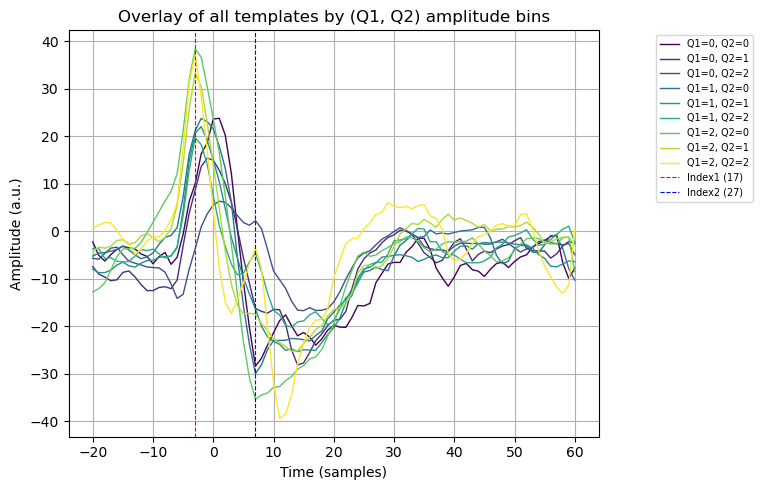

In [217]:
# --- Set your two reference timepoints ---
index1 = 17#peak_indices[0]
index2 = 27#peak_indices[1]

# --- Amplitude at each timepoint ---
vals1 = centered_traces[index1, :]
vals2 = centered_traces[index2, :]

# Instead of fixed 4 bins (quartiles), set number of bins:
n_bins = 3  # or 3, or 6, etc.

# --- Get bin edges for each index ---
bin_edges1 = np.percentile(vals1, np.linspace(0, 100, n_bins + 1))
bin_edges2 = np.percentile(vals2, np.linspace(0, 100, n_bins + 1))

# --- Digitize values into bins ---
labels1 = np.digitize(vals1, bins=bin_edges1[1:-1])  # exclude first and last edge
labels2 = np.digitize(vals2, bins=bin_edges2[1:-1])


# --- Create template grid: templates[label1][label2] ---
# Initialize template grid
templates = [[None for _ in range(n_bins)] for _ in range(n_bins)]

# Build templates
for i in range(n_bins):
    for j in range(n_bins):
        idx = np.where((labels1 == i) & (labels2 == j))[0]
        if len(idx) > 0:
            templates[i][j] = np.mean(centered_traces[:, idx], axis=1)
        else:
            templates[i][j] = np.zeros(centered_traces.shape[0])  # or np.nan


plt.figure(figsize=(8, 5))

colors = plt.cm.viridis(np.linspace(0, 1, n_bins*n_bins))  # 16 unique colors

for i in range(n_bins):
    for j in range(n_bins):
        template = templates[i][j]
        if template is not None:
            idx = i * n_bins + j
            label = f'Q1={i}, Q2={j}'
            plt.plot(t, template, label=label, color=colors[idx], linewidth=1)

plt.axvline(t[index1], color='red', linestyle='--', linewidth=0.8, label=f'Index1 ({index1})')
plt.axvline(t[index2], color='blue', linestyle='--', linewidth=0.8, label=f'Index2 ({index2})')

plt.title('Overlay of all templates by (Q1, Q2) amplitude bins')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (a.u.)')
plt.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()



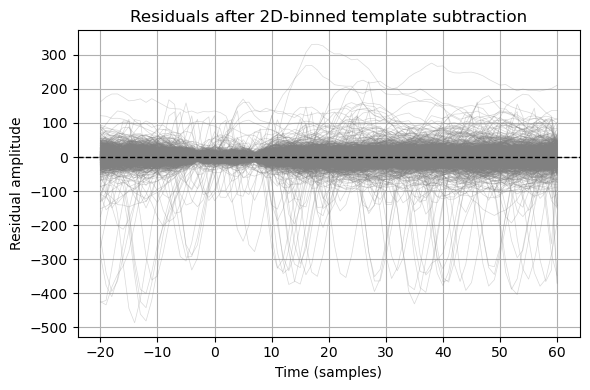

In [218]:
# --- Step 1: Subtract per-spike best-fit template based on labels1 and labels2 ---
residuals = np.zeros_like(centered_traces)

for i in range(centered_traces.shape[1]):
    l1 = labels1[i]
    l2 = labels2[i]
    template = templates[l1][l2]
    residuals[:, i] = centered_traces[:, i] - template

# --- Step 2: Plot residuals (overlay) ---
plt.figure(figsize=(6, 4))
for i in range(residuals.shape[1]):
    plt.plot(t, residuals[:, i], color='gray', alpha=0.3, linewidth=0.5)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals after 2D-binned template subtraction')
plt.xlabel('Time (samples)')
plt.ylabel('Residual amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


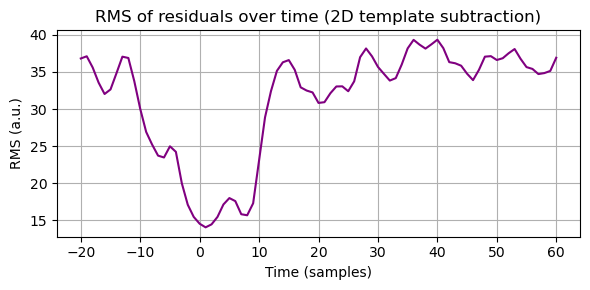

In [219]:
rms = np.sqrt(np.mean(residuals**2, axis=1))

plt.figure(figsize=(6, 3))
plt.plot(t, rms, color='purple')
plt.title('RMS of residuals over time (2D template subtraction)')
plt.xlabel('Time (samples)')
plt.ylabel('RMS (a.u.)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Full pipeline

### Step 1: Extract all snippets

In [220]:
# Parameters

spike_times = all_spikes[179]

window = (-20, 60)
n_channels = 512
dtype = 'int16'

# Extract all snippets
snips = extract_snippets(dat_path=dat_path,
                         spike_times=spike_times,
                         window=window,
                         n_channels=n_channels,
                         dtype=dtype)  # shape: [C x T x N]

t = np.arange(window[0], window[1] + 1)  # Time axis


### Step 2: Plot a single spike

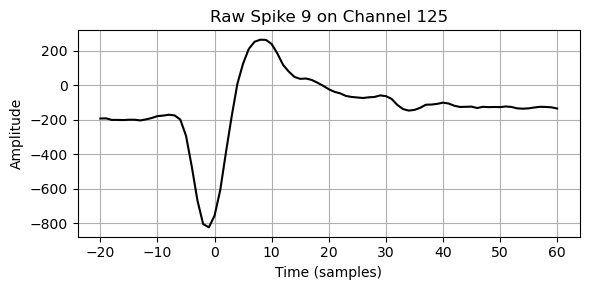

In [225]:
# Choose spike index and channel
spike_idx = 9
ref_channel = 126-1

plt.figure(figsize=(6, 3))
plt.plot(t, snips[ref_channel, :, spike_idx], color='black')
plt.title(f'Raw Spike {spike_idx} on Channel {ref_channel}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 3: Align all by a chosen spike on a reference channel

In [226]:
from scipy.signal import correlate

max_lag = 3          # max shift allowed

ref_trace = snips[ref_channel, :, spike_idx]
n_spikes = snips.shape[2]
shifts = []

for i in range(n_spikes):
    trace = snips[ref_channel, :, i]
    xc = correlate(trace, ref_trace, mode='full')
    center = len(xc) // 2
    window_xc = xc[center - max_lag:center + max_lag + 1]
    shift = np.argmax(window_xc) - max_lag
    shifts.append(shift)


### Step 4: Align arbitrary channel by those shifts

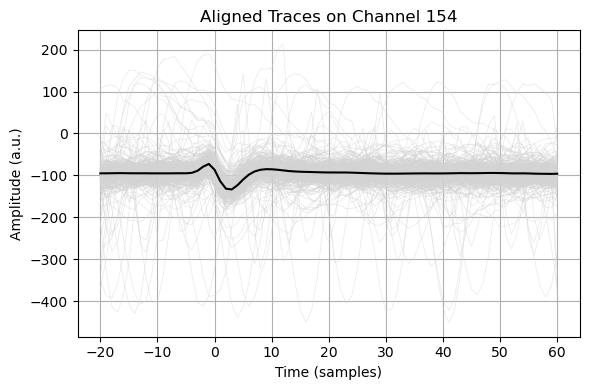

In [ ]:
align_channel = 155-1  # channel that we are aligning

aligned_traces = np.zeros((snips.shape[1], n_spikes))  # [T x N]
for i, s in enumerate(shifts):
    aligned_traces[:, i] = np.roll(snips[align_channel, :, i], -s)

import random

# --- Plot 300 random aligned traces + mean ---
plt.figure(figsize=(6, 4))

# Sample 300 random spike indices
np.random.seed(42)
sample_indices = np.random.choice(aligned_traces.shape[1], size=300, replace=False)

# Plot individual traces in light gray
for i in sample_indices:
    plt.plot(t, aligned_traces[:, i], color='lightgray', alpha=0.5, linewidth=0.5)

# Plot mean trace in black
mean_trace = np.mean(aligned_traces, axis=1)
plt.plot(t, mean_trace, color='black', linewidth=1.5, label='Mean waveform')

plt.title(f'Aligned Traces on Channel {align_channel}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (a.u.)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 5: Y-alignment (mean centering in a window)

In [272]:
y_start, y_end = 15, 30  # sample indices
centered_traces = np.zeros_like(aligned_traces)

for i in range(n_spikes):
    offset = np.mean(aligned_traces[y_start:y_end + 1, i])
    centered_traces[:, i] = aligned_traces[:, i] - offset


### Step 6: Subtract average template and compute RMS

In [273]:
template_avg = np.mean(centered_traces, axis=1)
residuals_avg = centered_traces - template_avg[:, None]
rms_avg = np.sqrt(np.mean(residuals_avg**2, axis=1))


### Step 7: Identify 2 RMS peaks

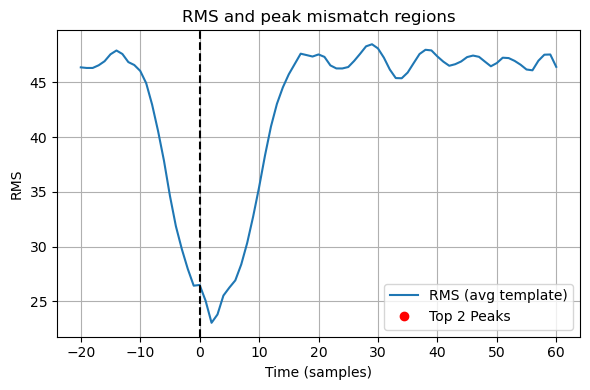

In [274]:
from scipy.signal import find_peaks

peaks, props = find_peaks(rms_avg, prominence=5)
top2 = np.argsort(props['prominences'])[::-1][:2]
peak_indices = peaks[top2]
peak_times = t[peak_indices]

# Plot RMS + peaks
plt.figure(figsize=(6, 4))
plt.plot(t, rms_avg, label='RMS (avg template)')
plt.plot(peak_times, rms_avg[peak_indices], 'ro', label='Top 2 Peaks')
plt.axvline(0, color='black', linestyle='--')
plt.legend()
plt.title('RMS and peak mismatch regions')
plt.xlabel('Time (samples)')
plt.ylabel('RMS')
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 8: Construct templates by 2D binning at peak locations

In [275]:
n_bins = 5

if len(peak_indices) < 2:
    # No valid peaks — use a single template for all
    template_avg = np.mean(centered_traces, axis=1)
    templates = [[template_avg]]  # 1×1 template grid
    labels1 = np.zeros(centered_traces.shape[1], dtype=int)
    labels2 = np.zeros(centered_traces.shape[1], dtype=int)
    n_bins = 1  # override
else:
    # Use 2D binning at RMS peaks
    idx1, idx2 = peak_indices

    vals1 = centered_traces[idx1, :]
    vals2 = centered_traces[idx2, :]

    edges1 = np.percentile(vals1, np.linspace(0, 100, n_bins + 1))
    edges2 = np.percentile(vals2, np.linspace(0, 100, n_bins + 1))

    labels1 = np.digitize(vals1, bins=edges1[1:-1])
    labels2 = np.digitize(vals2, bins=edges2[1:-1])

    templates = [[None for _ in range(n_bins)] for _ in range(n_bins)]

    for i in range(n_bins):
        for j in range(n_bins):
            idx = np.where((labels1 == i) & (labels2 == j))[0]
            if len(idx) > 0:
                templates[i][j] = np.mean(centered_traces[:, idx], axis=1)
            else:
                templates[i][j] = np.zeros(centered_traces.shape[0])


### Step 9: Subtract best-fitting template per spike

In [276]:
residuals_fuzzy = np.zeros_like(centered_traces)

for i in range(n_spikes):
    l1, l2 = labels1[i], labels2[i]
    template = templates[l1][l2]
    residuals_fuzzy[:, i] = centered_traces[:, i] - template


### Step 10: Compute and plot final RMS

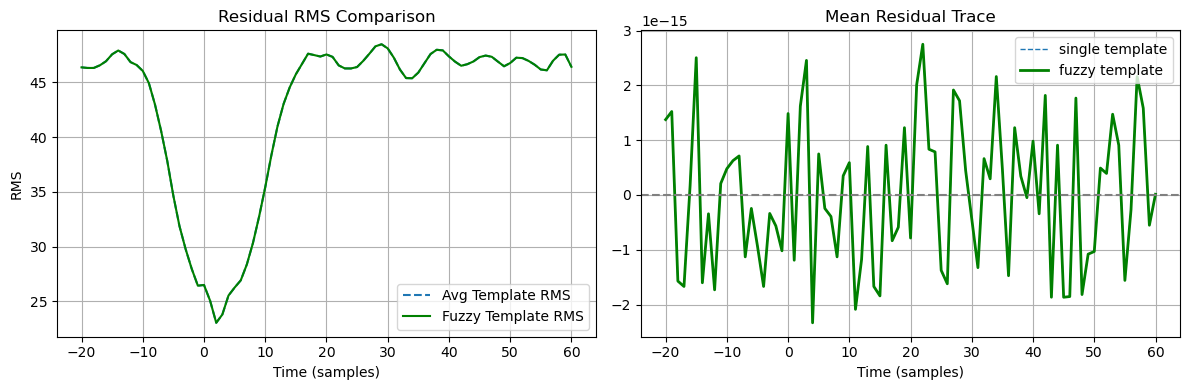

In [277]:
rms_fuzzy = np.sqrt(np.mean(residuals_fuzzy**2, axis=1))
mean_residual_fuzzy = np.mean(residuals_fuzzy, axis=1)
mean_residual = np.mean(residuals_avg, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# --- Left: RMS comparison ---
axs[0].plot(t, rms_avg, label='Avg Template RMS', linestyle='--')
axs[0].plot(t, rms_fuzzy, label='Fuzzy Template RMS', color='green')

if len(peak_indices) >= 2:
    axs[0].axvline(t[idx1], color='red', linestyle='--', label='Peak 1')
    axs[0].axvline(t[idx2], color='blue', linestyle='--', label='Peak 2')

axs[0].set_title('Residual RMS Comparison')
axs[0].set_xlabel('Time (samples)')
axs[0].set_ylabel('RMS')
axs[0].legend()
axs[0].grid(True)

# --- Right: Mean residual trace ---
axs[1].plot(t, mean_residual, linestyle='--',linewidth=1, label='single template')
axs[1].plot(t, mean_residual_fuzzy, color='green', linewidth=2, label='fuzzy template')
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_title('Mean Residual Trace')
axs[1].set_xlabel('Time (samples)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



### read a small segment of data to test subtraction

In [433]:
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'  

# --- Parameters ---
samples_to_load = 20000  # 1s of data
start_sample = 0         # starting point in the file
n_channels = 512
dtype = np.int16
channel_subset = np.array([126, 118, 123, 160, 157, 156, 163, 155, 154, 117, 143 ])-1  # or np.array([100, 120, 164, ...])

# --- Compute number of int16 values to read ---
samples_per_channel = samples_to_load
values_to_read = samples_per_channel * n_channels

# --- Memory-map the file, read into RAM ---
with open(dat_path, 'rb') as f:
    f.seek(start_sample * n_channels * np.dtype(dtype).itemsize)
    raw_flat = np.fromfile(f, dtype=dtype, count=values_to_read)

# --- Reshape to [channels x time] ---
raw_block_full = raw_flat.reshape((-1, n_channels)).T  # [C x T]

# --- Subset channels (optional) ---
raw_block = raw_block_full[channel_subset, :]  # [subset C x T]

# --- Convert to float32 for processing ---
raw_block = raw_block.astype(np.float32)

print(f"Loaded raw block: {raw_block.shape[1]} samples x {raw_block.shape[0]} channels")


Loaded raw block: 20000 samples x 11 channels


### plot single channel, unmodified

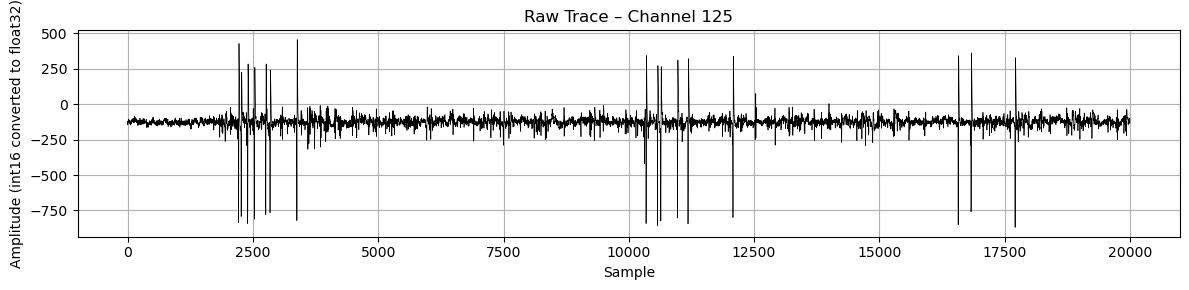

In [434]:
# --- Choose channel index (within raw_block, not original MEA index) ---
channel_idx = 0  # e.g., first channel in channel_subset

# --- Time axis (in samples) ---
time_axis = np.arange(raw_block.shape[1])  # 0 to 19999

# --- Plot raw trace ---
plt.figure(figsize=(12, 3))
plt.plot(time_axis, raw_block[channel_idx, :], color='black', linewidth=0.5)
plt.title(f'Raw Trace – Channel {channel_subset[channel_idx]}')
plt.xlabel('Sample')
plt.ylabel('Amplitude (int16 converted to float32)')
plt.grid(True)
plt.tight_layout()
plt.show()


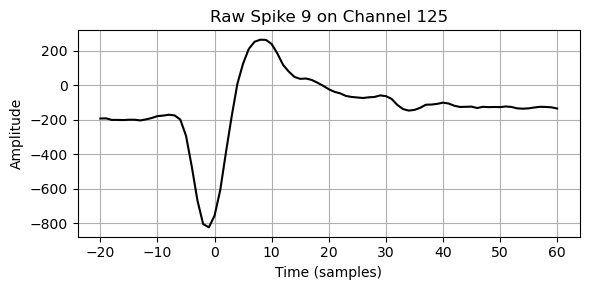

In [435]:
# Choose spike index and channel
spike_idx = 9
ref_channel = 126-1

plt.figure(figsize=(6, 3))
plt.plot(t, snips[ref_channel, :, spike_idx], color='black')
plt.title(f'Raw Spike {spike_idx} on Channel {ref_channel}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [436]:
from scipy.signal import correlate

max_lag = 3          # max shift allowed

ref_trace = snips[ref_channel, :, spike_idx]
n_spikes = snips.shape[2]
shifts = []

for i in range(n_spikes):
    trace = snips[ref_channel, :, i]
    xc = correlate(trace, ref_trace, mode='full')
    center = len(xc) // 2
    window_xc = xc[center - max_lag:center + max_lag + 1]
    shift = np.argmax(window_xc) - max_lag
    shifts.append(shift)


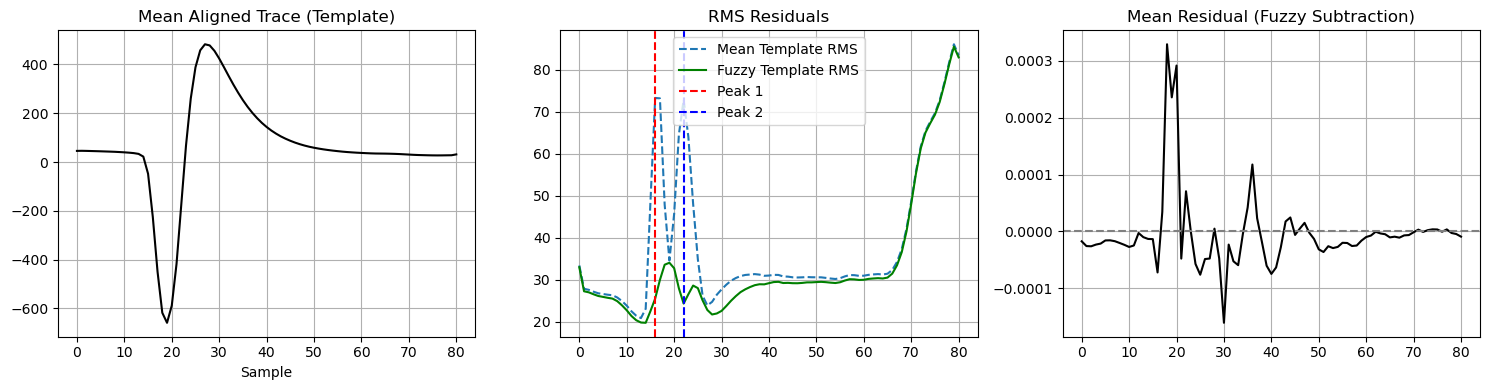

(16, 22)


In [437]:
import build_templates
import importlib
importlib.reload(build_templates)
import numpy as np

align_channel = 126-1

shifts = np.array(shifts)

aligned_traces, templates, template_ids, mean_template, peak_indices = build_templates.build_templates(snips=snips, 
                                                                                       align_channel=align_channel, 
                                                                                       x_shifts = shifts, 
                                                                                       window=(10, 30), 
                                                                                       n_bins=3,
                                                                                       peak_indices=None)

print(peak_indices)

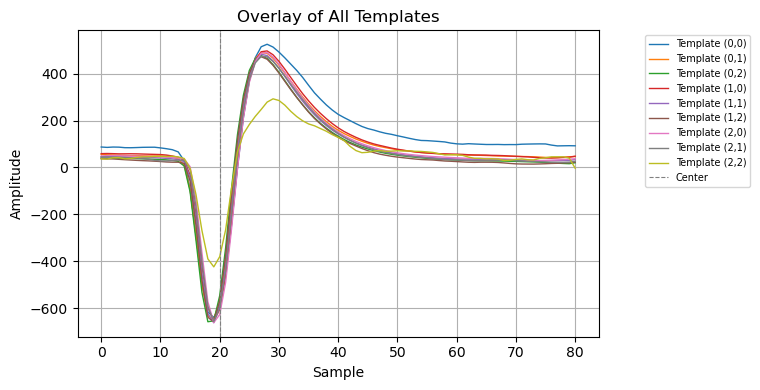

In [438]:
plt.figure(figsize=(8, 4))

# Determine if 2D or 1D structure
if isinstance(templates[0], list):  # 2D grid of templates
    n_bins = len(templates)
    for i in range(n_bins):
        for j in range(n_bins):
            plt.plot(templates[i][j], label=f'Template ({i},{j})', linewidth=1)
else:  # fallback mode: single template
    plt.plot(templates[0], label='Template (0,0)', linewidth=1)

# Optional vertical line at center (default index 20)
plt.axvline(20, color='gray', linestyle='--', linewidth=0.8, label='Center')

plt.title("Overlay of All Templates")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


[ 2215  2267  2397  2531  2757  2843  3378 10347 10575 10640 10973 11184
 12080 16575 16832 17710]


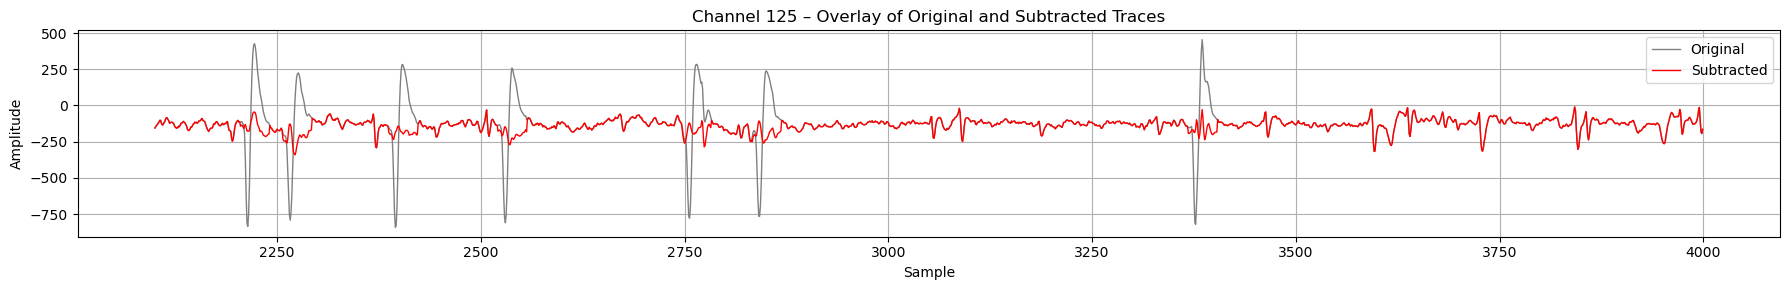

In [439]:
import subtract_templates_from_channel_block
import importlib
importlib.reload(subtract_templates_from_channel_block)
import plot_subtraction_overlay
importlib.reload(plot_subtraction_overlay)


align_index = np.where(channel_subset == align_channel)[0][0]

start_sample = 0
end_sample = 20000

# Find indices of spikes that fall within the sample window
spikes_to_take = np.where((spike_times >= start_sample) & (spike_times < end_sample))[0]
template_ids_block = [template_ids[i] for i in spikes_to_take]

raw_block_subtracted = raw_block[align_index, :].copy()

raw_block_subtracted = subtract_templates_from_channel_block.subtract_templates_from_channel_block(
    raw_block=raw_block_subtracted,
    spike_times_block=spike_times[spikes_to_take],
    x_shifts=shifts[spikes_to_take],
    templates=templates,
    template_ids=template_ids_block,
    start_sample=start_sample,
    template_center=20,
    subtraction_window=(-10, 25)
)

print(spike_times[spikes_to_take])

plot_subtraction_overlay.plot_subtraction_overlay(raw_block[align_index, :],
                         raw_block_subtracted,
                         start_sample_plot=2100,
                         end_sample_plot=4000,
                         channel_label=f"Channel {channel_subset[align_index]}")

30
330
2727
347
2382
357
2709
374
3


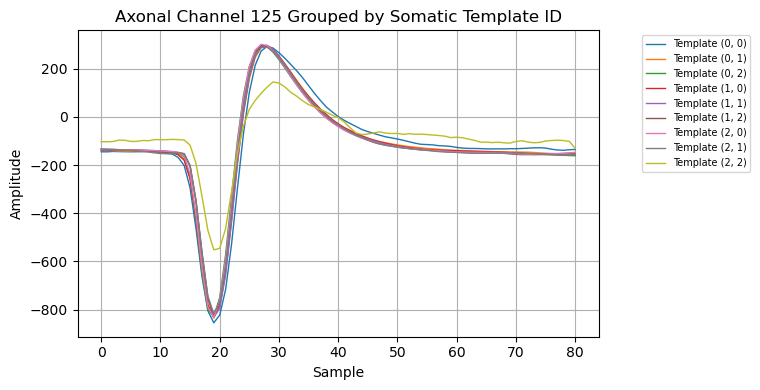

In [557]:
# Unique template IDs used
unique_ids = list(set(template_ids))

# Sort them for clean plotting

channel_ax = 126-1

plt.figure(figsize=(8, 4))
unique_ids = sorted(set(template_ids))

for tid in unique_ids:
    idx = np.array([i for i, t in enumerate(template_ids) if t == tid])
    print(len(idx))
    if len(idx) == 0:
        continue

    mean_waveform = np.mean(snips[channel_ax][:, idx], axis=1)  # clean, correct

    plt.plot(mean_waveform, label=f'Template {tid}', linewidth=1)

plt.title(f'Axonal Channel {channel_ax} Grouped by Somatic Template ID')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(fontsize=7, loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()




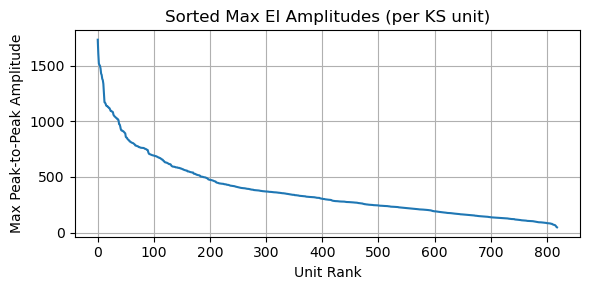

54


In [414]:
import h5py
import numpy as np

h5_ei_path = '/Volumes/Lab/Users/alexth/axolotl/ks_eis_subset.h5'

ks_templates = {}
with h5py.File(h5_ei_path, 'r') as f:
    for k in f.keys():
        ks_templates[int(k.split('_')[1])] = f[k][:]
ks_unit_ids = list(ks_templates.keys())
ks_ei_stack = np.stack([ks_templates[k] for k in ks_unit_ids], axis=0)  # [N x 512 x 81]

# Compute peak-to-peak per channel, per unit
peak_to_peak = ks_ei_stack.max(axis=2) - ks_ei_stack.min(axis=2)  # shape: [N x 512]

# Get maximum value across all channels per unit
unit_max_amp = peak_to_peak.max(axis=1)  # shape: [N]

# Get sorting indices (descending)
sorted_indices = np.argsort(unit_max_amp)[::-1]

# Reorder unit IDs by amplitude
ks_unit_ids_sorted = [ks_unit_ids[i] for i in sorted_indices]
unit_max_amp_sorted = unit_max_amp[sorted_indices]

# Optional: visualize top amplitudes
plt.figure(figsize=(6, 3))
plt.plot(unit_max_amp_sorted)
plt.title('Sorted Max EI Amplitudes (per KS unit)')
plt.xlabel('Unit Rank')
plt.ylabel('Max Peak-to-Peak Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

print(ks_unit_ids_sorted[0])

### Actual raw file subtraction

In [496]:
spike_times = all_spikes[179]
print(len(spike_times))
print(len(shifts))
print(len(template_ids))
print(len(templates))
print(spike_times[:10])

9259
9259
9259
5
[ 2215  2267  2397  2531  2757  2843  3378 10347 10575 10640]


In [441]:
import numpy as np

# Parameters
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'
dtype = np.int16
n_channels = 512
target_channel = 125  # zero-indexed
template_center = 20
window = (-10, 30)
snip_len = window[1] - window[0] + 1
bytes_per_sample = np.dtype(dtype).itemsize

# Open memmap
dat = np.memmap(dat_path, dtype=dtype, mode='r+', order='C')
total_samples = dat.size // n_channels

# Loop over spikes
for i in range(len(spike_times)):
    spike_time = spike_times[i]
    shift = shifts[i]
    template_id = template_ids[i]

    t_aligned = spike_time + shift
    t0 = t_aligned + window[0]
    t1 = t0 + snip_len

    if t0 < 0 or t1 >= total_samples:
        continue  # Skip out-of-bounds

    # Get template slice
    if isinstance(template_id, tuple):
        full_template = templates[template_id[0]][template_id[1]]
    else:
        full_template = templates[template_id]
    cut_start = template_center + window[0]
    cut_end = template_center + window[1] + 1
    template_cut = full_template[cut_start:cut_end]

    # Compute file indices for this snippet
    sample_indices = np.arange(t0, t1)
    indices = sample_indices * n_channels + target_channel

    # Read, subtract, write
    trace_segment = dat[indices].astype(np.float32)
    trace_subtracted = np.clip(trace_segment - template_cut, -32768, 32767).astype(np.int16)
    dat[indices] = trace_subtracted


print("Subtraction complete for unit 179 on channel 125.")


Subtraction complete for unit 179 on channel 125.


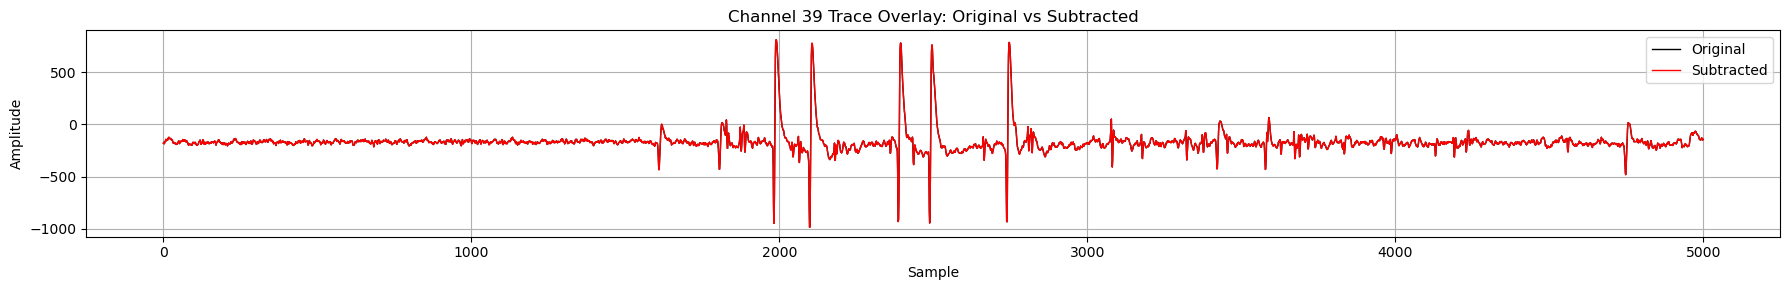

In [616]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
channel = 39  # zero-indexed
n_channels = 512
dtype = np.int16
start_sample = 0
end_sample = 5000
samples_to_read = end_sample - start_sample
bytes_per_sample = np.dtype(dtype).itemsize

# File paths
raw_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
sub_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

def read_channel_segment(dat_path, channel, start_sample, samples_to_read, n_channels=512, dtype=np.int16):
    with open(dat_path, 'rb') as f:
        # Compute flat indices: one per sample
        indices = np.arange(samples_to_read) * n_channels + channel + start_sample * n_channels

        # Read the whole file into memory (or use memmap if large)
        f.seek(0)
        raw_flat = np.fromfile(f, dtype=dtype, count=np.max(indices) + 1)

        # Extract just the desired channel's samples
        return raw_flat[indices].astype(np.float32)

# Read both traces
trace_raw = read_channel_segment(raw_path, channel, start_sample, samples_to_read)
trace_sub = read_channel_segment(sub_path, channel, start_sample, samples_to_read)

# Plot
time_axis = np.arange(start_sample, end_sample)

plt.figure(figsize=(18, 3))
plt.plot(time_axis, trace_raw, label='Original', color='black', linewidth=1)
plt.plot(time_axis, trace_sub, label='Subtracted', color='red', linewidth=1)
plt.title(f"Channel {channel} Trace Overlay: Original vs Subtracted")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Multi-channel subtraction

In [626]:
print(all_spikes[54][:5])

[1990 2106 2394 2496 2747]


23 18


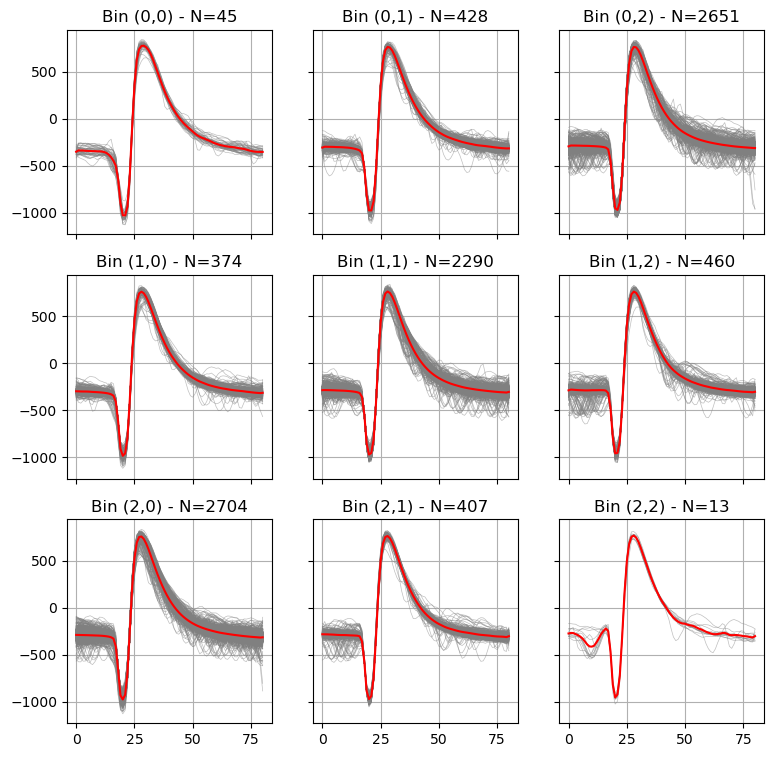

In [627]:
import prepare_subtraction_templates
import importlib
importlib.reload(prepare_subtraction_templates)

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
spike_times = all_spikes[54].copy()
spike_times = spike_times-8

ei_template, ei_channels, x_shifts, templates_by_chan, template_ids_by_chan, y_shifts_by_chan = prepare_subtraction_templates.prepare_subtraction_templates(dat_path=dat_path,
                                  spike_times=spike_times,
                                  EI_threshold=10,
                                  window=(-20, 60),
                                  max_lag=3,
                                  n_bins=3,
                                  n_channels=512,
                                  dtype=np.int16,
                                  subtraction_window=(10,50))

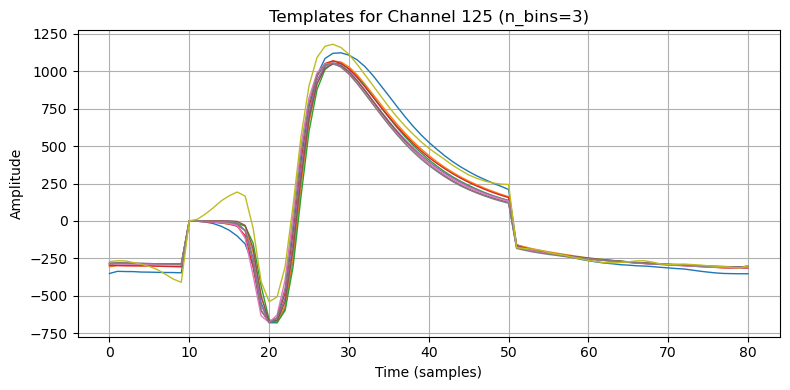

In [628]:
import matplotlib.pyplot as plt

templates = templates_by_chan[39]  # assumes it's a 5x5 grid from n_bins=5

plt.figure(figsize=(8, 4))

for i in range(len(templates[j])):
    for j in range(len(templates[i])):
        tpl = templates[i][j]
        if tpl is not None:
            plt.plot(tpl, label=f'({i},{j})', linewidth=1)

plt.title("Templates for Channel 125 (n_bins=3)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [583]:
print(template_ids_by_chan[125][:15])
for i, tid in enumerate(template_ids_by_chan[125]):
    if tid != (2, 2):
        print(f"First non-(2,2) template ID at spike {i}: {tid}")
        break


[(0, 2), (1, 1), (0, 2), (1, 1), (2, 1), (2, 0), (1, 0), (0, 2), (2, 0), (1, 0), (1, 1), (1, 1), (2, 0), (1, 1), (2, 0)]
First non-(2,2) template ID at spike 0: (0, 2)


In [584]:
from collections import Counter

counts = Counter(template_ids_by_chan[125])

for tid, count in sorted(counts.items()):
    print(f"Template ID {tid}: {count} spikes")


Template ID (0, 0): 90 spikes
Template ID (0, 1): 423 spikes
Template ID (0, 2): 2573 spikes
Template ID (1, 0): 434 spikes
Template ID (1, 1): 2146 spikes
Template ID (1, 2): 507 spikes
Template ID (2, 0): 2562 spikes
Template ID (2, 1): 516 spikes
Template ID (2, 2): 8 spikes


In [629]:
import subtract_unit_from_raw
import importlib
importlib.reload(subtract_unit_from_raw)

subtract_unit_from_raw.subtract_unit_from_raw(
    dat_path='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat',
    spike_times=spike_times,
    x_shifts=x_shifts,
    templates=templates_by_chan,        # a dict or list with one entry per channel
    template_ids=template_ids_by_chan,
    ei_waveform=ei_template,                # not used inside yet, but could be for plotting
    unit_id=54,
    target_channels=ei_channels,           # e.g. np.where(ei_peak2peak > 10)[0]
    start_sample=0,
    total_samples=36_000_000,
    template_center=20,
    subtraction_window=(-10, 30),
    n_channels=512,
    dtype=np.int16,
    y_shifts=None
)


Unit 54 subtraction complete.


In [587]:
print("Type:", type(y_shifts_by_chan[125]))
print("Shape:", np.shape(y_shifts_by_chan[125]))
print("First 10 y-shifts:", y_shifts_by_chan[125][:10])




Type: <class 'numpy.ndarray'>
Shape: (9259,)
First 10 y-shifts: [ -80.51219  -134.87805  -111.07317  -114.51219  -105.243904 -117.07317
  -87.78048   -85.34146  -116.46342  -112.731705]


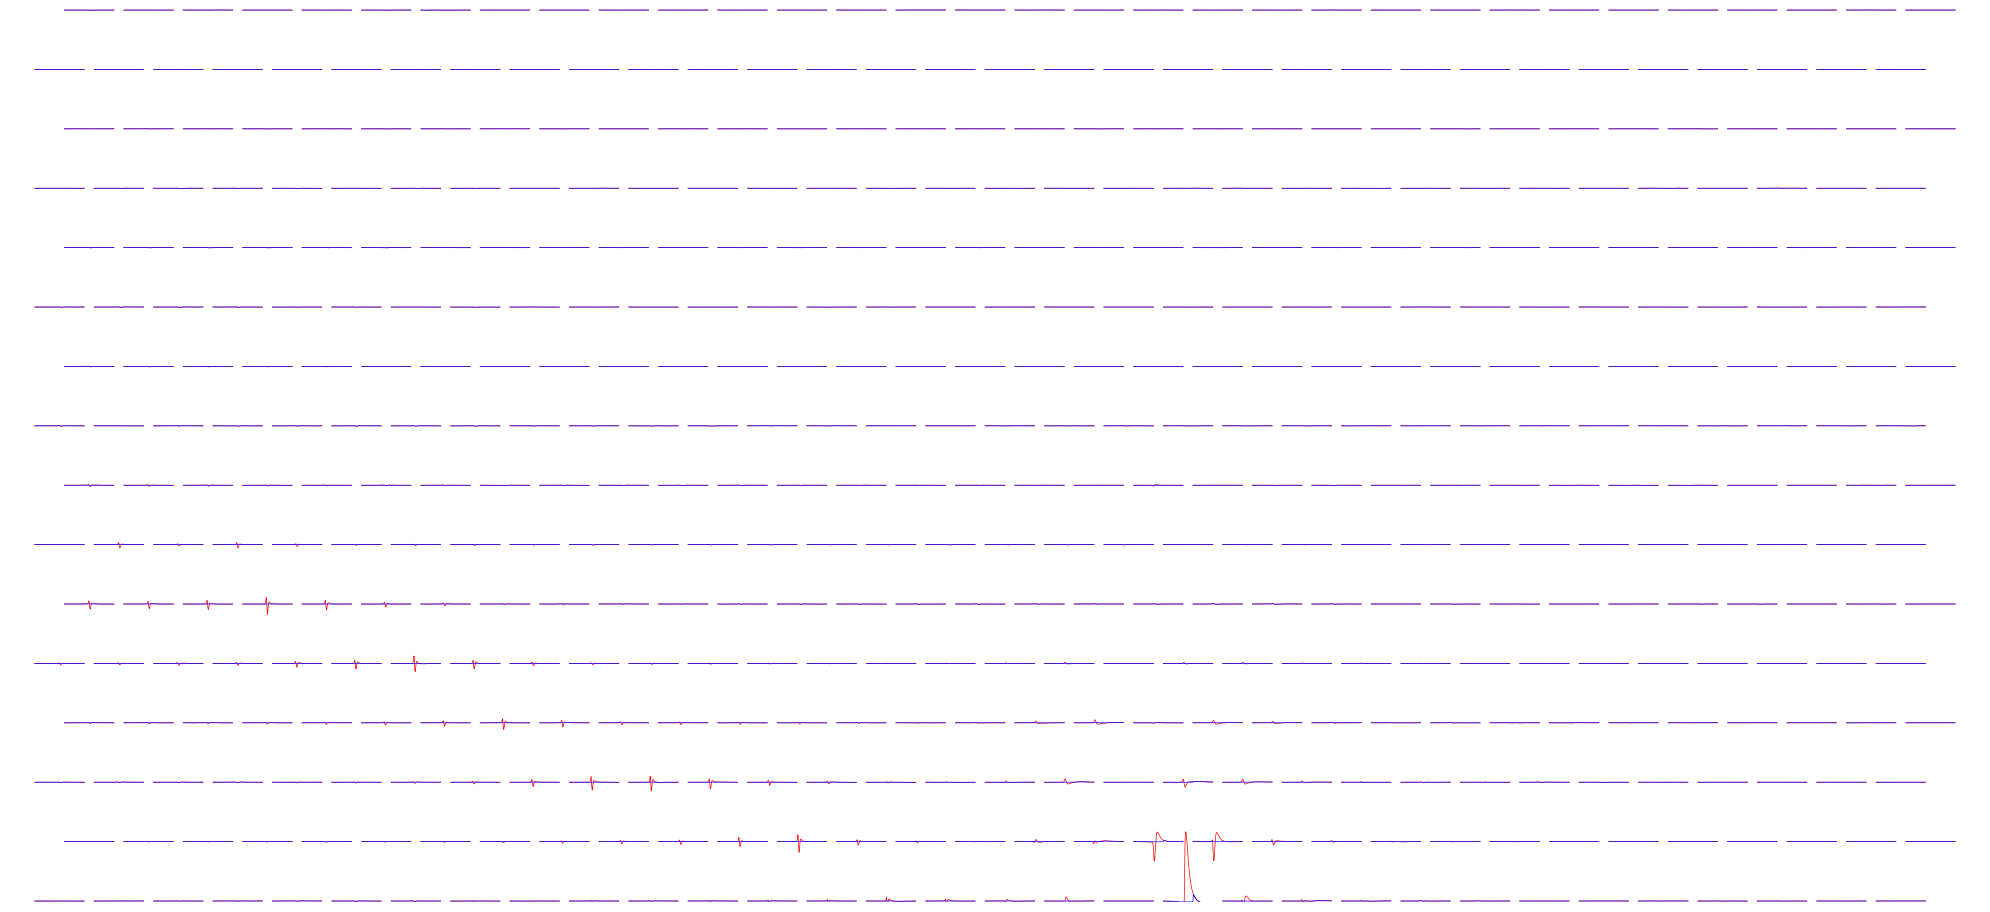

In [630]:
from extract_data_snippets import extract_snippets
from plot_ei_waveforms import plot_ei_waveforms
import matplotlib.pyplot as plt
import numpy as np
import h5py

h5_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'

with h5py.File(h5_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

spike_times1 = all_spikes[54].copy()
spike_times1 = spike_times1-8

# --- Parameters ---
window = (-60, 90)
n_channels = 512
dtype = 'int16'

# Paths
dat_path_orig = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
dat_path_sub = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

# Load snippets
snips_orig = extract_snippets(dat_path_orig, spike_times1, window=window, n_channels=n_channels, dtype=dtype)
snips_sub = extract_snippets(dat_path_sub, spike_times1, window=window, n_channels=n_channels, dtype=dtype)

# Compute EIs
ei_orig = np.mean(snips_orig, axis=2)
ei_sub = np.mean(snips_sub, axis=2)

# Baseline correction
ei_orig -= ei_orig[:, :5].mean(axis=1, keepdims=True)
ei_sub  -= ei_sub[:, :5].mean(axis=1, keepdims=True)

# --- Plot ---

plt.figure(figsize=(20,20))

plot_ei_waveforms([ei_orig, ei_sub], ei_positions,
                  colors=[ 'red', 'blue'], scale=70, box_height=1.0, box_width=50)

plt.tight_layout()
plt.show()


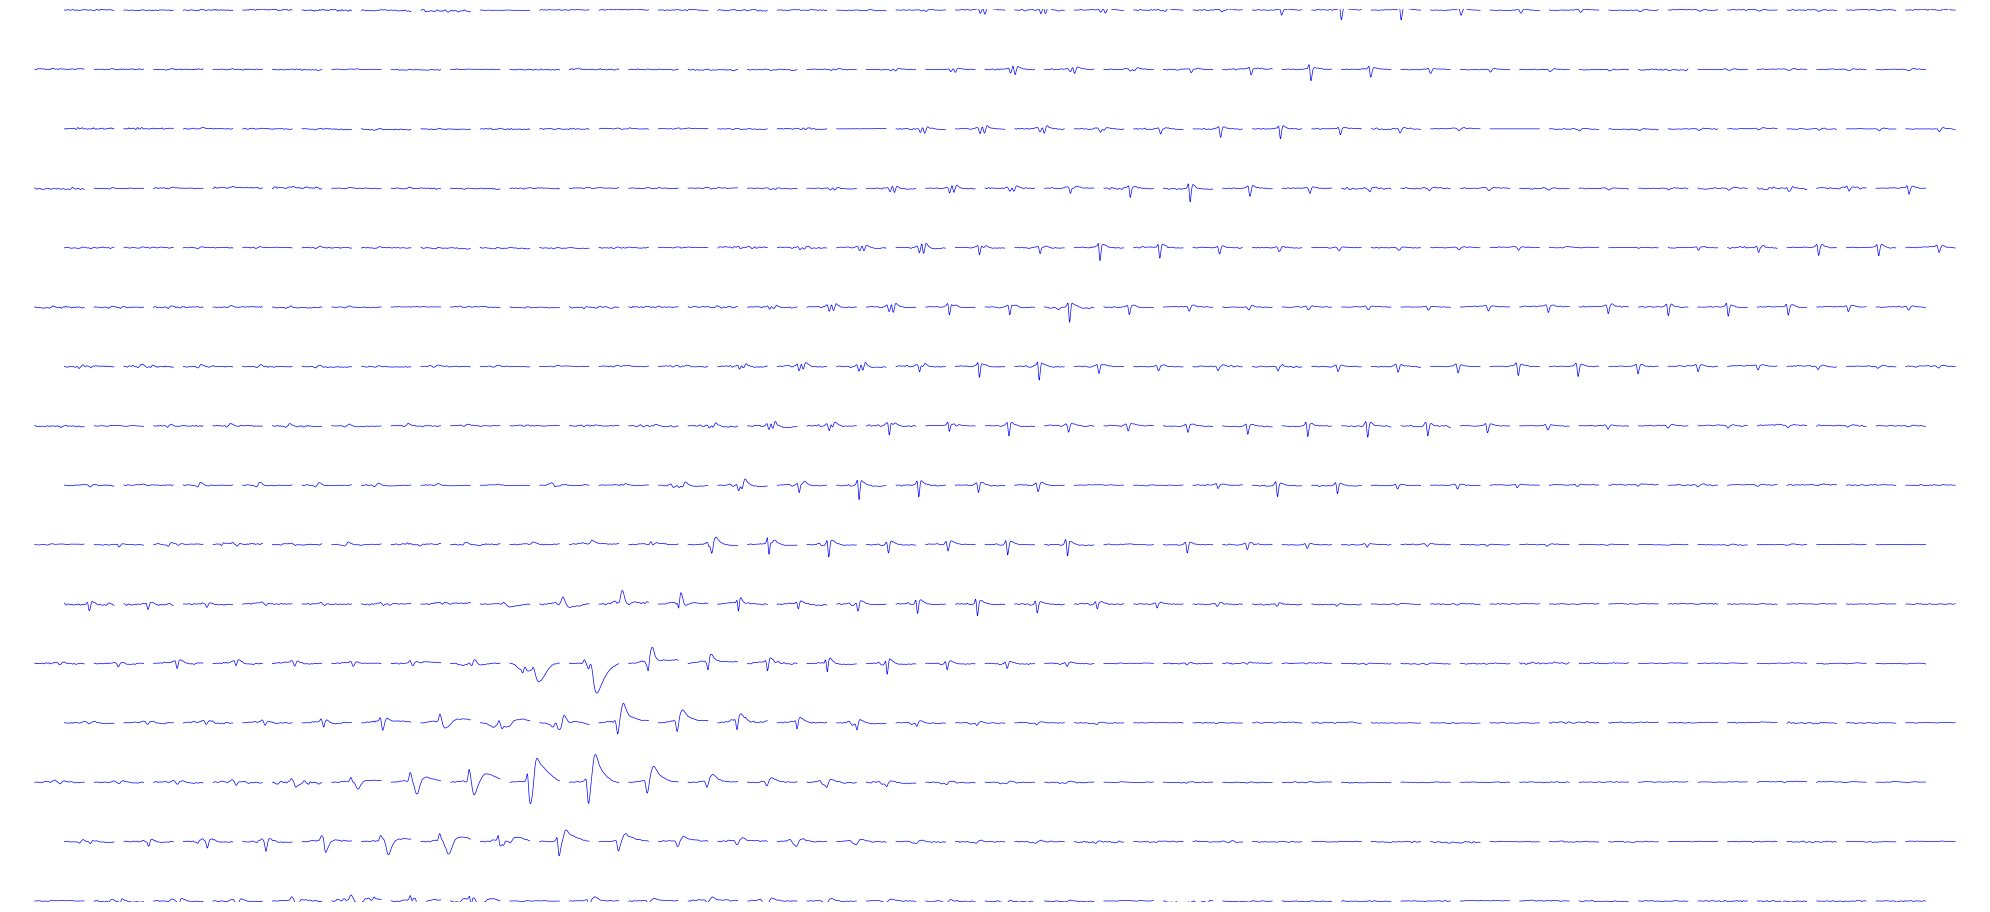

In [606]:
plt.figure(figsize=(20,20))

plot_ei_waveforms([ ei_sub], ei_positions,
                  colors=['blue'], scale=30, box_height=1.0, box_width=50)

plt.tight_layout()
plt.show()